### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
#from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBSBSS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


### Descriptive Statistics

In [2]:
def generate_statistics(T,param):
    print "Statistics for " + param
    print "25th Quantile ",numpy.nanpercentile(T, 25)
    print "50th Quantile ",numpy.nanpercentile(T, 50)
    print "75th Quantile ",numpy.nanpercentile(T, 75)
    print "Min ",numpy.nanmin(T)
    print "Max ",numpy.nanmax(T)
    print "NaN count ",np.count_nonzero(np.isnan(T))
    print "----------------------"

sqlContext.registerDataFrameAsTable(df,'weather')
for param in ['TMIN','TMAX','TOBS','PRCP','SNOW','SNWD']:
    Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%(param)
    df1 = sqlContext.sql(Query)
    rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
    T=np.vstack(rows)
    T=T/10.  # scaling to make the temperature be in centingrates
    generate_statistics(T,param)

Statistics for TMIN
25th Quantile  -6.1015625
50th Quantile  0.0
75th Quantile  6.69921875
Min  -25.0
Max  26.703
NaN count  31807
----------------------
Statistics for TMAX
25th Quantile  6.1015625
50th Quantile  14.3984375
75th Quantile  23.90625
Min  -11.102
Max  42.812
NaN count  35077
----------------------
Statistics for TOBS
25th Quantile  0.60009765625
50th Quantile  8.296875
75th Quantile  17.796875
Min  -17.203
Max  39.406
NaN count  30791
----------------------
Statistics for PRCP
25th Quantile  0.0
50th Quantile  0.0
75th Quantile  0.0
Min  0.0
Max  74.688
NaN count  13430
----------------------
Statistics for SNOW
25th Quantile  0.0
50th Quantile  0.0
75th Quantile  0.0
Min  0.0
Max  20.297
NaN count  16479
----------------------
Statistics for SNWD
25th Quantile  0.0
50th Quantile  0.0
75th Quantile  0.0
Min  0.0
Max  172.75
NaN count  13043
----------------------


### Kolmogorov–Smirnov statistic to compare distributions on different scales

In [3]:
from scipy.stats import ks_2samp

#taken from US climate data site
actual_TMAX_mean = [-0.2,3.2,8.1,14.2,19.7,24.9,29.2,29.2,22.7,16.2,6.5,1.3]
actual_TMIN_mean = [-13.5,-10.5,-5.6,-0.6,4.6,9.1,11.7,11.1,5.6,0.1,-6.9,-12]
actual_PRCP_mean = [13,8,21,29,69,58,50,39,31,19,11,13]

def compute_KS_statistic(m,actual_mean):
    print "Measurement " + m
    mean=STAT[m]['Mean'] / 10
    observed_mean = []
    if(m == 'PRCP'):
        observed_mean.append(np.sum(np.array(mean[:31]))) 
        observed_mean.append(np.sum(np.array(mean[31:59])))
        observed_mean.append(np.sum(np.array(mean[59:91])))
        observed_mean.append(np.sum(np.array(mean[91:122])))
        observed_mean.append(np.sum(np.array(mean[122:154])))
        observed_mean.append(np.sum(np.array(mean[154:185])))
        observed_mean.append(np.sum(np.array(mean[185:217])))
        observed_mean.append(np.sum(np.array(mean[217:249])))
        observed_mean.append(np.sum(np.array(mean[249:280])))
        observed_mean.append(np.sum(np.array(mean[280:312])))
        observed_mean.append(np.sum(np.array(mean[312:333])))
        observed_mean.append(np.sum(np.array(mean[333:364])))
    else:
        observed_mean.append(np.mean(np.array(mean[:31]))) 
        observed_mean.append(np.mean(np.array(mean[31:59])))
        observed_mean.append(np.mean(np.array(mean[59:91])))
        observed_mean.append(np.mean(np.array(mean[91:122])))
        observed_mean.append(np.mean(np.array(mean[122:154])))
        observed_mean.append(np.mean(np.array(mean[154:185])))
        observed_mean.append(np.mean(np.array(mean[185:217])))
        observed_mean.append(np.mean(np.array(mean[217:249])))
        observed_mean.append(np.mean(np.array(mean[249:280])))
        observed_mean.append(np.mean(np.array(mean[280:312])))
        observed_mean.append(np.mean(np.array(mean[312:333])))
        observed_mean.append(np.mean(np.array(mean[333:364])))
        
    print ks_2samp(actual_mean, observed_mean)
    
compute_KS_statistic('TMAX',actual_TMAX_mean)
compute_KS_statistic('TMIN',actual_TMIN_mean)   
compute_KS_statistic('PRCP',actual_PRCP_mean) 
    

Measurement TMAX
Ks_2sampResult(statistic=0.16666666666666669, pvalue=0.99133252540492101)
Measurement TMIN
Ks_2sampResult(statistic=0.25, pvalue=0.78641716217514468)
Measurement PRCP
Ks_2sampResult(statistic=0.25, pvalue=0.78641716217514468)


### Coefficient of variation statistic to compare distributions on same scale

In [4]:
m = 'SNWD'
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
print "Coefficient of variation for Mean distribution ",np.std(Mean) / np.mean(Mean)
print "Coefficient of variation for eig1 distribution ",np.std(STAT[m]['eigvec'][:,0]) / np.mean(STAT[m]['eigvec'][:,0])


Coefficient of variation for Mean distribution  1.18105139323
Coefficient of variation for eig1 distribution  1.06292371582


### Count of negative eigen values

In [5]:
eigvalues = STAT[m]['eigval'];
print sum(x < 0 for x in eigvalues),"out of",len(eigvalues),"eigen values are negative"

81 out of 365 eigen values are negative


In [14]:
from scipy import stats
def return_data(measurement):

    Query = "SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00243013')
    df = sqlContext.sql(Query)
    rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
    T = np.vstack(rows)
    return T

def plot_graph(T,measurement):
    final_list = []
    for x in T:
        final_list.append(np.nanmean(x))
    xi = np.arange(0,len(final_list))
    slope, intercept, r_value, p_value, std_err = stats.linregress(xi,final_list)
    line = slope*xi+intercept
    print "slope is :"+str(slope)
    plt.plot(xi,final_list,'o', xi, line)
    plt.title("Mean "+measurement+" statistics for past "+str(len(xi))+" years")
    plt.ylabel(measurement)
    plt.xlabel("years")

slope is :0.345850896999


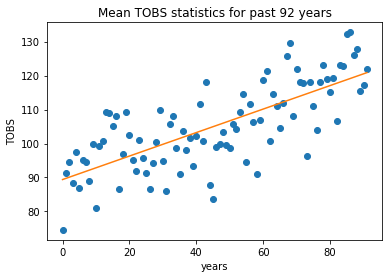

In [15]:
T = return_data('TOBS')
plot_graph(T,'TOBS')

slope is :0.345850896999


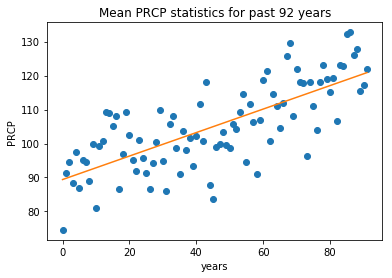

In [16]:
T = return_data('PRCP')
plot_graph(T,'PRCP')

slope is :0.345850896999


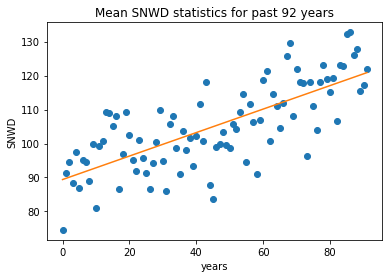

In [17]:
T = return_data('SNWD')
plot_graph(T,'SNWD')